In [1]:
from pandas import Timedelta, to_datetime
from matplotlib.pyplot import subplots, savefig, show, legend, close
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

subset_data: bool = False


def make_biometrics_plots_together_matplotlib(
    data: defaultdict[str, defaultdict[str, defaultdict[str, Series]]],
    user_id: str,
    session_id: str,
    dataset: str,
    experiment_info: DataFrame,
    **kwargs,
) -> None:
    data = {key: val for key, val in data.items() if val is not None}
    fig, axs = subplots(
        len(data.keys()), 1, figsize=(14, 11 * len(data.keys())), sharex=True
    )
    if len(data.keys()) == 1:
        axs = [axs]
    
    for n, (data_type, physiological_data) in tqdm(
        enumerate(data.items()), desc="Plotting data", total=len(data.keys())
    ):
        if physiological_data is None:
            continue

        for side, specific_side_data in physiological_data.items():
            user_data: DataFrame = specific_side_data[user_id]

            if data_type == "EDA":
                eda_type: str = kwargs["eda_type"]
                data_to_plot = user_data[eda_type]
            else:
                data_to_plot = user_data.iloc[:, 0]

            data_to_plot = data_to_plot.loc[IndexSlice[session_id, :]]
            if subset_data:
                data_to_plot = data_to_plot[:1000]

            data_to_plot.index = to_datetime(data_to_plot.index)
            axs[n].plot(
                data_to_plot.index,
                data_to_plot.values,
                label=side,
                linestyle="-",
            )
            axs[n].set_title(data_type)

            # del data_to_plot
            # garbage_collect()

        # session_id_corrected: Timestamp = to_datetime(
        #     session_ids["left"].split("-")[0], format="%y%m%d"
        # )  + Timedelta("1D")
        # session_id_corrected: str = str(session_id_corrected.date())
        if dataset == "mwc2022":
            start_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "actual_bed_time"]
            )
            end_exp = Timestamp(
                experiment_info.loc[IndexSlice[user_id, session_id], "wake_up_time"]
            )
            # start_exp = start_exp.tz_localize("Europe/Rome")
            # end_exp = end_exp.tz_localize("Europe/Rome")

            axs[n].axvspan(
                xmin=start_exp,
                xmax=end_exp,
                color="#828282",
                alpha=0.3,
                label="sleep time",
            )
            axs[n].set_ylabel(f"Time")
            axs[n].set_ylabel(f"{data_type}")
        elif dataset == "usi_laughs":
            events = set(
                ["_".join(col.split("_")[1:]) for col in experiment_info.columns]
            )
            for i, event in enumerate(events):
                start_exp = Timestamp(experiment_info.loc[user_id, f"start_{event}"])
                end_exp = Timestamp(experiment_info.loc[user_id, f"end_{event}"])
                if "baseline" in event and i == 0:
                    label = "baseline"
                elif "baseline" not in event:
                    label = event
                else:
                    label = None

                axs[n].axvspan(
                    xmin=start_exp,
                    xmax=end_exp,
                    color="#828282" if "baseline" in event else "#548572",
                    alpha=0.3,
                    label=label,
                )
                axs[n].set_ylabel(f"Time")
                axs[n].set_ylabel(f"{data_type}")
        else:
            raise ValueError(
                f"Received as dataset {dataset}, but only mwc2022 and usi_laughs are supported"
            )

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        fontsize="x-large",
        title="Side",
        title_fontsize="xx-large",
        #    loc='best'
    )
    # legend()
    fig.suptitle(
        f"Plots for all singals for user {user_id}, session {session_id}",
        fontsize=30,
        y=0.97,
    )
    savefig(f"../visualizations/{dataset}_{user_id}_{session_id}.pdf")
    # show()
    close()

    return start_exp, end_exp


# Intro

This notebook is intended to provide data exploration for all datasets concerning this Lateralization study. As the moment, the datasets impemented are:
* USILaughs
* MWC2022 study

I split the same notebook into 2, since I was having problems w/ remote working, due too large filesizes.

# USILaughs

## Cognitive Load Info

In [2]:
from pandas import read_csv, to_datetime
from pandas import IndexSlice, DataFrame
import pandas as pd

pd.options.display.precision = 5

In [3]:
def move_event_to_columns(df):
    starts = {}
    ends = {}
    for event in df.index.get_level_values(1).unique():
        starts[f"start_{event}"] = df.loc[IndexSlice[:, event], "start"].values
        ends[f"end_{event}"] = df.loc[IndexSlice[:, event], "end"].values
    return DataFrame({**starts, **ends})


experiment_info = read_csv(
    "../data.nosync/usilaughs/all_experimento_info.csv", index_col=[0, 1]
)
indexes_to_drop = [
    idx
    for idx in experiment_info.index
    if "baseline" not in idx[1] and "cognitive_load" not in idx[1]
]
experiment_info = experiment_info.drop(indexes_to_drop, inplace=False)
experiment_info = experiment_info.groupby(axis=0, level=0, group_keys=True).apply(
    move_event_to_columns
)
experiment_info.index = experiment_info.index.droplevel(1)


In [4]:
experiment_info = experiment_info.applymap(to_datetime)
experiment_info = experiment_info.applymap(lambda x: x.tz_localize('Europe/Rome'))

## Physiological Data

In [5]:
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect

eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/usilaughs/filtered/*/ACC/*.parquet"

eda_data_paths: list[str] = glob(eda_data_base_path)
acc_data_paths: list[str] = glob(acc_data_base_path)
eda_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(eda_data_paths, desc="Loading EDA data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    eda_data[side_name][user_name] = read_parquet(file)
    
   
acc_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
) 
for file in tqdm(acc_data_paths, desc="Loading ACC data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    acc_data[side_name][user_name] = read_parquet(file)

bvp_data = None

# bvp_data_base_path: str = "../data/filtered/*/BVP/*.parquet"
# bvp_data_paths: list[str] = glob(bvp_data_base_path)
# bvp_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
#     lambda: defaultdict()
# )
# for file in tqdm(bvp_data_paths, desc="Loading BVP data"):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     bvp_data[side_name][user_name] = read_parquet(file)
    
    
physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]] = {
    "EDA": eda_data,
    "BVP": bvp_data,
    'ACC': acc_data,
}
del eda_data
del bvp_data
del acc_data
garbage_collect()

Loading EDA data:   0%|          | 0/67 [00:00<?, ?it/s]

Loading ACC data:   0%|          | 0/68 [00:00<?, ?it/s]

270

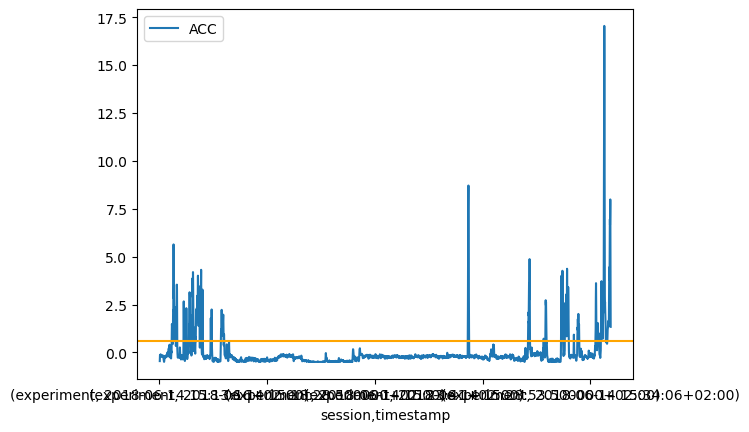

In [6]:
import matplotlib.pyplot as plt
physiological_data['ACC']['left']['s037'].plot()
plt.axhline(physiological_data['ACC']['left']['s037'].quantile(0.90)[0], color='orange')
plt.show()

After inspection, user 40 has to be removed, since his experiment time and the timestamps from the E4 do not match.

In [7]:
experiment_info = experiment_info.drop('s040', axis=0, inplace=False)
del physiological_data['EDA']['left']['s040']
del physiological_data['EDA']['right']['s040']
# del physiological_data['BVP']['left']['s040']
# del physiological_data['BVP']['right']['s040']

In [8]:
users_left = physiological_data["EDA"]["left"].keys()
users_right = physiological_data["EDA"]["right"].keys()
users = list(set(users_left) & set(users_right))
sessions_all = ['experiment']

In [8]:
# session = session_selection.value
for user in tqdm(sorted(users), desc='Plotting user data', colour='red'):
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data=physiological_data,
            user_id=user,
            session_id=session,
            dataset='usi_laughs',
            experiment_info=experiment_info,
            eda_type="mixed-EDA",
        )


Plotting user data:   0%|          | 0/32 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting data:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
users_in_left_side = set(physiological_data['EDA']['left'].keys())
users_in_right_side = set(physiological_data['EDA']['right'].keys())

In [10]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [11]:
experiment_info_as_dict: dict[str, Series] = {
    participant: experiment_info.loc[participant, :]
    for participant in list(experiment_info.index.unique())
}

In [12]:
segment_size_in_secs = 4
eda_sample_rate = 4
segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate

In [13]:
eda_data = physiological_data['EDA']

In [14]:
# user = "U13"
# info = experiment_info_as_dict[user]
# data = eda_data['left'][user]

In [15]:
from numpy import nan, ndarray
from pandas import Timedelta


def get_session_moment(start: Timestamp, end: Timestamp, info: Series) -> int | float:
    # TODO: check that this is working as expected
    # this method gives 0 if the person is awake and 1 if the person is
    if (end < info["end_baseline_1"]) or (
        (start < info["end_baseline_1"] and end > info["end_baseline_1"])
    ):
        return 0
    elif (start > info["end_baseline_1"] and end < info["start_cognitive_load"]) or (
        start > info["end_cognitive_load"]) or (
            start < info["start_cognitive_load"] and end > info["start_cognitive_load"]
        ):
        return nan
    else:
        return 1


data_segmented_left: list[tuple] = []
data_segmented_right: list[tuple] = []
users = list(set(eda_data["left"].keys()) & set(eda_data["right"].keys()))

for user in tqdm(users, desc='User progress', colour='blue'):
    data_left = eda_data["left"][user]
    data_right = eda_data["right"][user]
    info = experiment_info_as_dict[user]
    
    # FIXME: using sessions like this seems stupid, but allows to reuse code
    # from the other experiment. I should however find a way around it
    sessions_all = ['experiment']
    for session in sessions_all:
        session_data_left: DataFrame = data_left.loc[IndexSlice[session, :], :]
        session_data_right: DataFrame = data_right.loc[IndexSlice[session, :], :]

        session_info = info

        starts_left = session_data_left[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)
        starts_right = session_data_right[
            ::segment_size_in_sampling_rate
        ].index.get_level_values(1)

        ends_left = (
            session_data_left[::segment_size_in_sampling_rate].index.get_level_values(1)
            + Timedelta(f"{segment_size_in_secs}s")
            - Timedelta(f"{1/eda_sample_rate}s")
        )
        ends_right = (
            session_data_right[::segment_size_in_sampling_rate].index.get_level_values(
                1
            )
            + Timedelta(f"{segment_size_in_secs}s")
            - Timedelta(f"{1/eda_sample_rate}s")
        )

        segments_left = [
            (
                session_data_left.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
            )
            for start, end in zip(starts_left, ends_left)
        ]
        segments_right = [
            (
                session_data_right.loc[
                    IndexSlice[session, start:end],
                    "mixed-EDA",
                ].values,
                get_session_moment(start, end, session_info),
                user,
            )
            for start, end in zip(starts_right, ends_right)
        ]
        data_segmented_left.append(segments_left)
        data_segmented_right.append(segments_right)


User progress:   0%|          | 0/32 [00:00<?, ?it/s]

In [16]:
from numpy import isnan
values_left = [
    val[0]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
values_right = [
    val[0]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

labels_left = [
    val[1]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]
labels_right = [
    val[1]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

groups_left = [
    val[2]
    for segments in data_segmented_left
    for val in segments
    if not isnan(val[1])
]

groups_right = [
    val[2]
    for segments in data_segmented_right
    for val in segments
    if not isnan(val[1])
]

0    480
1    384
dtype: int64
0    55.55556
1    44.44444
dtype: float64


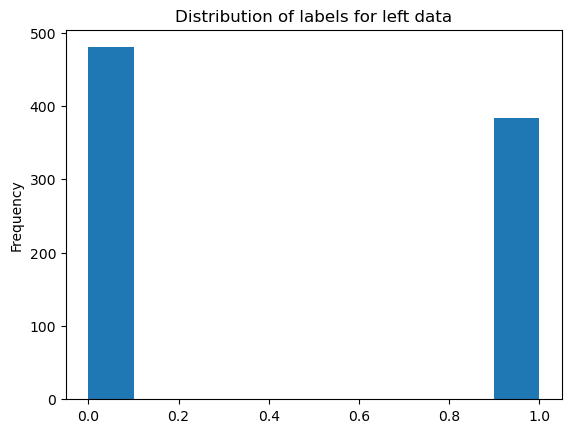

In [20]:
import matplotlib.pyplot as plt

Series(labels_left).plot(kind="hist")
plt.title('Distribution of labels for left data')
print(Series(labels_left).value_counts())
print(Series(labels_left).value_counts()/Series(labels_left).count()*100)

0    480
1    384
dtype: int64
0    55.55556
1    44.44444
dtype: float64


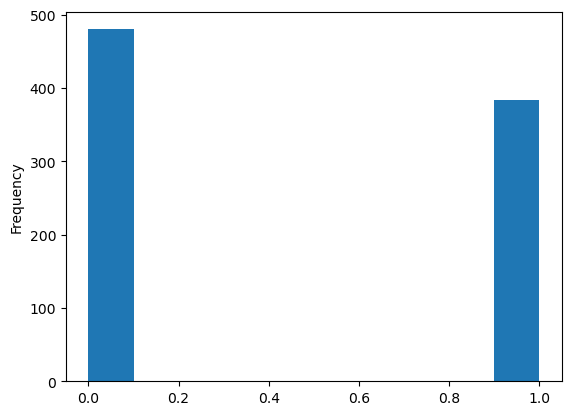

In [18]:
Series(labels_right).plot(kind="hist")
print(Series(labels_right).value_counts())
print(Series(labels_right).value_counts()/Series(labels_right).count()*100)

The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In this case, we do not perform feature extraction: we try to train the classifiers using the raw signals. While w/ traditional machine learning it may be tricky, it is not impossible and can still lead to good results.

In [26]:
from numpy import stack

features_left: ndarray = stack(values_left)
features_right: ndarray = stack(values_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)

In [27]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(864, 16)
labels_left.shape=(864,)
groups_left.shape=(864,)


# ML Prediction

In [28]:
from typing import Callable
from imblearn.under_sampling.base import BaseUnderSampler
from imblearn.under_sampling import (
    RandomUnderSampler,
    ClusterCentroids,
    NearMiss,
    TomekLinks,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    CondensedNearestNeighbour,
    OneSidedSelection,
    NeighbourhoodCleaningRule,
    InstanceHardnessThreshold,
)

def resampling(df: DataFrame, resampling_method: BaseUnderSampler = RandomUnderSampler, random_state: int = 42) -> DataFrame:
    x = df.drop(columns=["label"], inplace=False).values
    y = df["label"].values
    cc = resampling_method(random_state=random_state)
    x_resampled, y_resampled = cc.fit_resample(x, y)
    result = DataFrame(x_resampled)
    result['label'] = y_resampled
    return result

## 5-fold CV

In [29]:
from sklearn.model_selection import KFold
from lazypredict.Supervised import LazyClassifier
import pandas as pd
def run_cv_ml(x, y, groups):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values


    folds = KFold(n_splits=5, random_state=42, shuffle=True).split(x_resampled, y_resampled)
    all_models = []
    for train_index, test_index in tqdm(folds, desc="Folds progress:", total=5):
        x_train, x_test = x_resampled[train_index], x_resampled[test_index]
        y_train, y_test = y_resampled[train_index], y_resampled[test_index]
        clf = LazyClassifier(predictions=True)
        models, predictions = clf.fit(x_train, x_test, y_train, y_test)
        all_models.append(models)


    averages = (
        pd.concat(all_models)
        .groupby(level=0)
        .mean()
        .sort_values(by="Accuracy", ascending=False)
    )
    standard_deviations = (
        pd.concat(all_models)
        .groupby(level=0)
        .std()
        .sort_values(by="Accuracy", ascending=False)
    )
    standard_errors = standard_deviations / 5**0.5
    return pd.concat([averages, standard_errors], axis=1, keys=["Average", "Standard error"])

### LX v LX

In [30]:
run_cv_ml(features_left, labels_left, groups_left)

Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 22.52it/s]


Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
LabelPropagation                  0.69              0.69    0.69     0.69   
RandomForestClassifier            0.69              0.69    0.69     0.69   
LabelSpreading                    0.68              0.68    0.68     0.68   
SVC                               0.68              0.68    0.68     0.67   
ExtraTreesClassifier              0.68              0.68    0.68     0.68   
AdaBoostClassifier                0.67              0.67    0.67     0.66   
XGBClassifier                     0.66              0.66    0.66     0.66   
KNeighborsClassifier              0.66              0.66    0.66     0.66   
DecisionTreeClassifier            0.65              0.65    0.65     0.65   
BaggingClassifier                 0.65              0.65    0.65     0.65   
LGBMClassifier                    0.65              0.65    0.65     0.64   
ExtraTreeClassifier               0.64              0.63    0.63     0.63   
GaussianNB                        0.63              0.63    0.63     0.63   
LinearSVC                         0.63              0.63    0.63     0.63   
RidgeClassifier                   0.63              0.63    0.63     0.63   
CalibratedClassifierCV            0.63              0.63    0.63     0.63   
NearestCentroid                   0.63              0.63    0.63     0.62   
BernoulliNB                       0.62              0.62    0.62     0.62   
LogisticRegression                0.62              0.63    0.63     0.62   
RidgeClassifierCV                 0.62              0.62    0.62     0.62   
PassiveAggressiveClassifier       0.61              0.61    0.61     0.60   
LinearDiscriminantAnalysis        0.61              0.61    0.61     0.61   
QuadraticDiscriminantAnalysis     0.57              0.57    0.57     0.53   
SGDClassifier                     0.54              0.54    0.54     0.54   
NuSVC                             0.51              0.51    0.51     0.51   
DummyClassifier                   0.47              0.50    0.50     0.30   
Perceptron                        0.41              0.41    0.41     0.41   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
LabelPropagation                    0.01           0.02              0.02   
RandomForestClassifier              0.12           0.02              0.02   
LabelSpreading                      0.01           0.02              0.01   
SVC                                 0.01           0.02              0.02   
ExtraTreesClassifier                0.08           0.01              0.01   
AdaBoostClassifier                  0.06           0.01              0.01   
XGBClassifier                       0.35           0.02              0.02   
KNeighborsClassifier                0.01           0.03              0.03   
DecisionTreeClassifier              0.01           0.02              0.02   
BaggingClassifier                   0.03           0.02              0.02   
LGBMClassifier                      0.37           0.01              0.01   
ExtraTreeClassifier                 0.00           0.01              0.01   
GaussianNB                          0.00           0.01              0.01   
LinearSVC                           0.03           0.01              0.02   
RidgeClassifier                     0.01           0.02              0.02   
CalibratedClassifierCV              0.11           0.02              0.02   
NearestCentroid                     0.00           0.01              0.02   
BernoulliNB                         0.00           0.02              0.02   
LogisticRegression                  0.01           0.02              0.02   
RidgeClassifierCV         

### RX vs RX

In [31]:
run_cv_ml(features_right, labels_right, groups_right)

Folds progress::   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:01<00:00, 23.93it/s]


Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier            0.78              0.78    0.78     0.78   
NuSVC                             0.77              0.77    0.77     0.77   
SVC                               0.77              0.77    0.77     0.77   
AdaBoostClassifier                0.77              0.77    0.77     0.77   
LabelPropagation                  0.77              0.77    0.77     0.77   
LabelSpreading                    0.77              0.77    0.77     0.77   
ExtraTreesClassifier              0.76              0.76    0.76     0.76   
KNeighborsClassifier              0.76              0.76    0.76     0.76   
BaggingClassifier                 0.75              0.75    0.75     0.75   
LGBMClassifier                    0.75              0.75    0.75     0.75   
XGBClassifier                     0.74              0.74    0.74     0.74   
GaussianNB                        0.72              0.72    0.72     0.72   
DecisionTreeClassifier            0.72              0.72    0.72     0.72   
ExtraTreeClassifier               0.71              0.71    0.71     0.71   
LogisticRegression                0.71              0.71    0.71     0.71   
PassiveAggressiveClassifier       0.71              0.70    0.70     0.70   
LinearSVC                         0.71              0.71    0.71     0.71   
RidgeClassifier                   0.71              0.71    0.71     0.71   
CalibratedClassifierCV            0.70              0.70    0.70     0.70   
RidgeClassifierCV                 0.70              0.70    0.70     0.70   
NearestCentroid                   0.70              0.70    0.70     0.70   
BernoulliNB                       0.70              0.70    0.70     0.70   
LinearDiscriminantAnalysis        0.70              0.70    0.70     0.70   
Perceptron                        0.62              0.62    0.62     0.62   
QuadraticDiscriminantAnalysis     0.58              0.59    0.59     0.55   
SGDClassifier                     0.55              0.55    0.55     0.55   
DummyClassifier                   0.47              0.50    0.50     0.30   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier              0.11           0.01              0.01   
NuSVC                               0.01           0.01              0.01   
SVC                                 0.01           0.01              0.01   
AdaBoostClassifier                  0.06           0.02              0.02   
LabelPropagation                    0.01           0.01              0.02   
LabelSpreading                      0.01           0.01              0.01   
ExtraTreesClassifier                0.07           0.01              0.01   
KNeighborsClassifier                0.01           0.01              0.01   
BaggingClassifier                   0.03           0.02              0.02   
LGBMClassifier                      0.35           0.01              0.01   
XGBClassifier                       0.32           0.02              0.02   
GaussianNB                          0.00           0.01              0.01   
DecisionTreeClassifier              0.01           0.01              0.01   
ExtraTreeClassifier                 0.00           0.02              0.02   
LogisticRegression                  0.01           0.01              0.01   
PassiveAggressiveClassifier         0.00           0.01              0.02   
LinearSVC                           0.03           0.01              0.00   
RidgeClassifier                     0.01           0.01              0.01   
CalibratedClassifierCV              0.11           0.01              0.01   
RidgeClassifierCV         

### LX vs RX

In [32]:
def local_resampling(x, y, groups, resampling_method: BaseUnderSampler = RandomUnderSampler):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling, resampling_method=resampling_method)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values
    return x_resampled, y_resampled, groups

In [33]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
models, predictions = clf.fit(x_resampled_lx, x_resampled_rx, y_resampled_lx, y_resampled_rx)
models.sort_values(by="Balanced Accuracy", ascending=False)

100%|██████████| 29/29 [00:01<00:00, 20.09it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.77,0.77,0.77,0.77,0.03
GaussianNB,0.72,0.72,0.72,0.72,0.00
LabelPropagation,0.71,0.71,0.71,0.71,0.02
PassiveAggressiveClassifier,0.71,0.71,0.71,0.71,0.00
LabelSpreading,0.71,0.71,0.71,0.71,0.02
CalibratedClassifierCV,0.71,0.71,0.71,0.71,0.14
RidgeClassifier,0.71,0.71,0.71,0.71,0.00
LinearSVC,0.71,0.71,0.71,0.71,0.04
KNeighborsClassifier,0.70,0.70,0.70,0.70,0.01


### RX vs LX

In [34]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
models, predictions = clf.fit(x_resampled_rx, x_resampled_lx, y_resampled_rx, y_resampled_lx)
models.sort_values(by="Balanced Accuracy", ascending=False)

100%|██████████| 29/29 [00:01<00:00, 20.03it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.68,0.68,0.68,0.68,0.08
BaggingClassifier,0.67,0.67,0.67,0.67,0.04
LabelSpreading,0.67,0.67,0.67,0.67,0.02
LabelPropagation,0.67,0.67,0.67,0.67,0.02
RandomForestClassifier,0.67,0.67,0.67,0.67,0.13
AdaBoostClassifier,0.67,0.67,0.67,0.67,0.07
XGBClassifier,0.67,0.67,0.67,0.67,0.39
SVC,0.66,0.66,0.66,0.65,0.02
LGBMClassifier,0.66,0.66,0.66,0.66,0.38


## 5-fold CV - different seeds

In [35]:
from sklearn.model_selection import StratifiedKFold
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed


def run_cv_ml_multiple_seeds(x, y, groups):
    data = DataFrame(x, index=groups)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    groups = data_resampled.index.get_level_values(0).values

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 10
    random_states_classifiers = randint(
        0, int(2**32 - 1), n_seeds_to_test_classifiers
    )

    set_numpy_seed(666)
    n_seeds_to_test_folds: int = 10
    random_states_folds = randint(0, int(2**32 - 1), n_seeds_to_test_folds)

    for random_state_folds in tqdm(
        random_states_folds, desc="Random states folds progress:", colour="blue"
    ):
        for random_state_classifier in tqdm(
            random_states_classifiers,
            desc="Random states classifiers progress:",
            colour="green",
        ):
            # NOTE: the fold generation should be fixed, to limit the accuracy
            # be due exclusively to starting confitions in the algorithm
            folds = StratifiedKFold(
                n_splits=5, random_state=random_state_folds, shuffle=True
            ).split(x_resampled, y_resampled)
            # TODO: we should iterate over different random states for the fold
            # generation as well, but independent from the random seeds for the algorithm
            # all_models = []
            # for train_index, test_index in folds:
            #     x_train, x_test = x_resampled[train_index], x_resampled[test_index]
            #     y_train, y_test = y_resampled[train_index], y_resampled[test_index]
            #     clf = LazyClassifier(predictions=True, random_state=random_state_classifier)
            #     models, predictions = clf.fit(x_train, x_test, y_train, y_test)
            #     all_models.append(models)
            from joblib import Parallel, delayed

            def run_fold(train_index, test_index):
                x_train, x_test = x_resampled[train_index], x_resampled[test_index]
                y_train, y_test = y_resampled[train_index], y_resampled[test_index]
                clf = LazyClassifier(
                    predictions=True, random_state=random_state_classifier
                )
                models, predictions = clf.fit(x_train, x_test, y_train, y_test)
                return models

            all_models = Parallel(n_jobs=-1)(
                delayed(run_fold)(train_index, test_index)
                for train_index, test_index in folds
            )

            averages = (
                pd.concat(all_models)
                .groupby(level=0)
                .mean()
                .sort_values(by="Accuracy", ascending=False)
            )
            standard_deviations = (
                pd.concat(all_models)
                .groupby(level=0)
                .std()
                .sort_values(by="Accuracy", ascending=False)
            )
            standard_errors = standard_deviations / 5**0.5
            results.append(
                pd.concat(
                    [averages, standard_errors],
                    axis=1,
                    keys=["Average", "Standard error"],
                )
            )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers * n_seeds_to_test_folds)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat(
        [averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]
    )


### LX vs LX

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [36]:
result = run_cv_ml_multiple_seeds(features_left, labels_left, groups_left)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 39.63it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 39.21it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 39.45it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 39.43it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 39.13it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 39.15it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 39.58it/s]

100%|██████████| 29/29 [00:00<00:00, 39.52it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 39.19it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 39.34it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 39.26it/s]


In [37]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(result)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.6841            0.6841  0.6841   0.6835   
RandomForestClassifier          0.6828            0.6828  0.6828   0.6821   
LabelPropagation                0.6798            0.6798  0.6798   0.6792   
LabelSpreading                  0.6794            0.6794  0.6794   0.6788   
SVC                             0.6785            0.6785  0.6785   0.6704   
AdaBoostClassifier              0.6763            0.6762  0.6762   0.6686   
BaggingClassifier               0.6605            0.6604  0.6604   0.6589   
KNeighborsClassifier            0.6599            0.6598  0.6598   0.6591   
XGBClassifier                   0.6580            0.6580  0.6580   0.6571   
LGBMClassifier                  0.6577            0.6576  0.6576   0.6568   
ExtraTreeClassifier             0.6409            0.6408  0.6408   0.6399   
DecisionTreeClassifier          0.6371            0.6370  0.6370   0.6360   
GaussianNB                      0.6364            0.6364  0.6364   0.6327   
CalibratedClassifierCV          0.6347            0.6347  0.6347   0.6337   
RidgeClassifier                 0.6286            0.6286  0.6286   0.6280   
LinearSVC                       0.6277            0.6276  0.6276   0.6271   
RidgeClassifierCV               0.6268            0.6268  0.6268   0.6262   
NearestCentroid                 0.6260            0.6259  0.6259   0.6253   
LogisticRegression              0.6255            0.6255  0.6255   0.6249   
BernoulliNB                     0.6234            0.6233  0.6233   0.6227   
LinearDiscriminantAnalysis      0.6101            0.6101  0.6101   0.6094   
QuadraticDiscriminantAnalysis   0.5710            0.5710  0.5710   0.5267   
NuSVC                           0.5648            0.5648  0.5648   0.5627   
SGDClassifier                   0.5564            0.5564  0.5564   0.5434   
PassiveAggressiveClassifier     0.5530            0.5530  0.5530   0.5215   
Perceptron                      0.5468            0.5468  0.5468   0.5332   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0787         0.0018            0.0018   
RandomForestClassifier            0.1270         0.0018            0.0018   
LabelPropagation                  0.0075         0.0016            0.0016   
LabelSpreading                    0.0094         0.0016            0.0016   
SVC                               0.0142         0.0015            0.0016   
AdaBoostClassifier                0.0598         0.0013            0.0013   
BaggingClassifier                 0.0350         0.0018            0.0017   
KNeighborsClassifier              0.0059         0.0019            0.0019   
XGBClassifier                     0.0979         0.0016            0.0016   
LGBMClassifier                    0.0533         0.0017            0.0017   
ExtraTreeClassifier               0.0041         0.0018            0.0018   
DecisionTreeClassifier            0.0082         0.0019            0.0019   
GaussianNB                        0.0039         0.0022            0.0022   
CalibratedClassifierCV            0.1185         0.0018            0.0018   
RidgeClassifier                   0.0043         0.0019            0.0019   
LinearSVC                         0.0309         0.0019            0.0019   
RidgeClassifierCV                 0.0045         0.0020            0.0020   
NearestCentroid                   0.0038         0.0021            0.0021   
LogisticRegression                0.0064         0.0019            0.0019   
BernoulliNB               

### RX vs RX

In [38]:
result = run_cv_ml_multiple_seeds(features_right, labels_right, groups_right)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 41.76it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 41.47it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 41.59it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 41.63it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 41.70it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 41.35it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 41.79it/s]

100%|██████████| 29/29 [00:00<00:00, 41.78it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 41.54it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 41.92it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 41.92it/s]


In [39]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(result)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.7780            0.7780  0.7780   0.7764   
NuSVC                           0.7777            0.7777  0.7777   0.7763   
LabelSpreading                  0.7757            0.7757  0.7757   0.7751   
LabelPropagation                0.7736            0.7736  0.7736   0.7731   
ExtraTreesClassifier            0.7735            0.7735  0.7735   0.7732   
RandomForestClassifier          0.7679            0.7679  0.7679   0.7676   
AdaBoostClassifier              0.7668            0.7669  0.7669   0.7649   
KNeighborsClassifier            0.7580            0.7580  0.7580   0.7576   
XGBClassifier                   0.7537            0.7536  0.7536   0.7533   
LGBMClassifier                  0.7529            0.7529  0.7529   0.7525   
BaggingClassifier               0.7496            0.7496  0.7496   0.7490   
GaussianNB                      0.7237            0.7237  0.7237   0.7216   
ExtraTreeClassifier             0.7186            0.7186  0.7186   0.7182   
DecisionTreeClassifier          0.7157            0.7156  0.7156   0.7152   
CalibratedClassifierCV          0.7061            0.7061  0.7061   0.7055   
NearestCentroid                 0.7041            0.7041  0.7041   0.7036   
LogisticRegression              0.7036            0.7036  0.7036   0.7032   
RidgeClassifier                 0.7029            0.7028  0.7028   0.7024   
RidgeClassifierCV               0.7026            0.7026  0.7026   0.7021   
BernoulliNB                     0.7023            0.7023  0.7023   0.7018   
LinearSVC                       0.6996            0.6996  0.6996   0.6992   
LinearDiscriminantAnalysis      0.6918            0.6918  0.6918   0.6913   
SGDClassifier                   0.6258            0.6257  0.6257   0.6168   
Perceptron                      0.6007            0.6007  0.6007   0.5914   
PassiveAggressiveClassifier     0.5947            0.5947  0.5947   0.5611   
QuadraticDiscriminantAnalysis   0.5841            0.5840  0.5840   0.5488   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0116         0.0013            0.0013   
NuSVC                             0.0132         0.0014            0.0014   
LabelSpreading                    0.0095         0.0015            0.0015   
LabelPropagation                  0.0076         0.0014            0.0014   
ExtraTreesClassifier              0.0738         0.0013            0.0013   
RandomForestClassifier            0.1167         0.0013            0.0013   
AdaBoostClassifier                0.0604         0.0015            0.0015   
KNeighborsClassifier              0.0054         0.0013            0.0013   
XGBClassifier                     0.0926         0.0014            0.0014   
LGBMClassifier                    0.0506         0.0015            0.0015   
BaggingClassifier                 0.0309         0.0015            0.0015   
GaussianNB                        0.0039         0.0020            0.0020   
ExtraTreeClassifier               0.0040         0.0015            0.0015   
DecisionTreeClassifier            0.0075         0.0015            0.0015   
CalibratedClassifierCV            0.1182         0.0016            0.0016   
NearestCentroid                   0.0037         0.0020            0.0020   
LogisticRegression                0.0059         0.0019            0.0019   
RidgeClassifier                   0.0043         0.0019            0.0019   
RidgeClassifierCV                 0.0044         0.0019            0.0019   
BernoulliNB               

### LOSO

#### Support

In [40]:
from lazypredict.Supervised import LazyClassifier


def train_score_single_model(
    groups_train: ndarray[str],
    groups_test: ndarray[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int,
    user: str,
) -> DataFrame:
    train_data_mask: ndarray = groups_train != user
    train_data: ndarray = x_train[train_data_mask]
    test_data_mark: ndarray = groups_test == user
    test_data: ndarray = x_test[test_data_mark]

    train_labels: ndarray = y_train[train_data_mask]
    test_labels: ndarray = y_test[test_data_mark]

    clf = ml_model(predictions=True, random_state=classifier_seed)

    models, predictions = clf.fit(
        X_train=train_data,
        X_test=test_data,
        y_train=train_labels,
        y_test=test_labels,
    )
    return models


def LOSO(
    groups_train: list[str],
    groups_test: list[str],
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    ml_model: LazyClassifier,
    classifier_seed: int = 42,
    n_jobs: int = 1,
):
    if n_jobs == 1:
        scores = [
            train_score_single_model(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        ]
    else:
        scores = Parallel(n_jobs=n_jobs)(
            delayed(train_score_single_model)(
                groups_train=groups_train,
                groups_test=groups_test,
                x_train=x_train,
                x_test=x_test,
                y_train=y_train,
                y_test=y_test,
                ml_model=ml_model,
                classifier_seed=classifier_seed,
                user=user,
            )
            for user in set(groups_train)
        )
    return scores


In [41]:
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack
    
def run_same_side_classifications(x, y, folds):
    # x_with_folds = hstack([x, folds.reshape(-1, 1)])
    # cc = RandomUnderSampler(random_state=42)
    # x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    # x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    # folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    # del x_with_folds_resampled
    data = DataFrame(x, index=folds)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    folds_resampled = data_resampled.index.get_level_values(0).values

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(0, int(2**32 - 1), n_seeds_to_test_classifiers)

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress:",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_train=folds_resampled,
            groups_test=folds_resampled,
            x_train=x_resampled,
            x_test=x_resampled,
            y_train=y_resampled,
            y_test=y_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=-1,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat([averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"])

In [44]:
from typing import Callable
from imblearn.under_sampling import (
    RandomUnderSampler,
)
from joblib import Parallel, delayed
from lazypredict.Supervised import LazyClassifier
import pandas as pd
from numpy.random import randint, seed as set_numpy_seed
from numpy import hstack


def under_sampling(
    x: ndarray,
    y: ndarray,
    folds: ndarray,
    resampling_method: Callable,
    random_state: int = 42,
) -> tuple[ndarray, ndarray, ndarray]:
    
    data = DataFrame(x, index=folds)
    data["label"] = y
    data_resampled = data.groupby(axis=0, level=0).apply(resampling, resampling_method=resampling_method, random_state=random_state)
    x_resampled = data_resampled.drop(columns=["label"], inplace=False).values
    y_resampled = data_resampled["label"].values
    folds_resampled = data_resampled.index.get_level_values(0).values
    # x_with_folds = hstack([x, folds.reshape(-1, 1)])
    # cc = resampling_method(random_state=random_state)
    # x_with_folds_resampled, y_resampled = cc.fit_resample(x_with_folds, y)

    # x_resampled = x_with_folds_resampled[:, :-1].astype(float)
    # folds_resampled = x_with_folds_resampled[:, -1].astype(str)
    return x_resampled, y_resampled, folds_resampled


def run_different_classifications(
    x_train: ndarray,
    x_test: ndarray,
    y_train: ndarray,
    y_test: ndarray,
    folds_train: int,
    folds_test: int,
    n_jobs: int,
) -> DataFrame:
    x_train_resampled, y_train_resampled, folds_train_resampled = under_sampling(
        x_train, y_train, folds_train, RandomUnderSampler, random_state=42
    )
    x_test_resampled, y_test_resampled, folds_test_resampled = under_sampling(
        x_test, y_test, folds_test, RandomUnderSampler, random_state=42
    )

    results = []
    # NOTE: we still set a single seed, from which we generate a bunch of other
    # random seeds to be fed to the algorithm
    set_numpy_seed(42)
    n_seeds_to_test_classifiers: int = 30
    random_states_classifiers = randint(
        0, int(2**32 - 1), n_seeds_to_test_classifiers
    )

    for random_state_classifier in tqdm(
        random_states_classifiers,
        desc="Random states classifiers progress",
        colour="green",
    ):
        # TODO: we should iterate over different random states for the fold
        # generation as well, but independent from the random seeds for the algorithm
        classifier = LazyClassifier
        all_models = LOSO(
            groups_train=folds_train_resampled,
            groups_test=folds_test_resampled,
            x_train=x_train_resampled,
            x_test=x_test_resampled,
            y_train=y_train_resampled,
            y_test=y_test_resampled,
            ml_model=classifier,
            classifier_seed=random_state_classifier,
            n_jobs=n_jobs,
        )

        averages = (
            pd.concat(all_models)
            .groupby(level=0)
            .mean()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_deviations = (
            pd.concat(all_models)
            .groupby(level=0)
            .std()
            .sort_values(by="Accuracy", ascending=False)
        )
        standard_errors = standard_deviations / 5**0.5
        results.append(
            pd.concat(
                [averages, standard_errors], axis=1, keys=["Average", "Standard error"]
            )
        )

    averages_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(lambda x: x.loc[:, IndexSlice["Average", :]].mean())
        .droplevel(axis=1, level=0)
        .sort_values(by=("Accuracy"), ascending=False)
    )

    errors_seeds = (
        pd.concat(results)
        .groupby(level=0)
        .apply(
            lambda x: (x.loc[:, IndexSlice["Standard error", :]] ** 2).sum() ** 0.5
            / (n_seeds_to_test_classifiers)
        )
        .droplevel(axis=1, level=0)
        .sort_values(by="Accuracy", ascending=False)
    )
    return pd.concat(
        [averages_seeds, errors_seeds], axis=1, keys=["Average", "Standard error"]
    )


#### Test with different seeds (LX vs LX)

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [45]:
results = run_same_side_classifications(features_left, labels_left, groups_left)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.39it/s]


In [46]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
GaussianNB                      0.6354            0.6354  0.6354   0.6029   
RidgeClassifierCV               0.6289            0.6289  0.6289   0.6044   
CalibratedClassifierCV          0.6263            0.6263  0.6263   0.6024   
SVC                             0.6250            0.6250  0.6250   0.5763   
NearestCentroid                 0.6250            0.6250  0.6250   0.6029   
BernoulliNB                     0.6237            0.6237  0.6237   0.6024   
RidgeClassifier                 0.6237            0.6237  0.6237   0.6001   
LinearSVC                       0.6217            0.6217  0.6217   0.5985   
LogisticRegression              0.6198            0.6198  0.6198   0.5944   
LinearDiscriminantAnalysis      0.6094            0.6094  0.6094   0.5851   
ExtraTreesClassifier            0.5958            0.5958  0.5958   0.5787   
RandomForestClassifier          0.5848            0.5848  0.5848   0.5672   
LabelSpreading                  0.5820            0.5820  0.5820   0.5547   
LabelPropagation                0.5794            0.5794  0.5794   0.5536   
XGBClassifier                   0.5716            0.5716  0.5716   0.5558   
BaggingClassifier               0.5712            0.5712  0.5712   0.5546   
AdaBoostClassifier              0.5711            0.5711  0.5711   0.5192   
ExtraTreeClassifier             0.5691            0.5691  0.5691   0.5554   
QuadraticDiscriminantAnalysis   0.5677            0.5677  0.5677   0.4795   
LGBMClassifier                  0.5599            0.5599  0.5599   0.5435   
DecisionTreeClassifier          0.5587            0.5587  0.5587   0.5447   
KNeighborsClassifier            0.5560            0.5560  0.5560   0.5366   
PassiveAggressiveClassifier     0.5421            0.5421  0.5421   0.4811   
SGDClassifier                   0.5372            0.5372  0.5372   0.4976   
Perceptron                      0.5311            0.5311  0.5311   0.4937   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   
NuSVC                           0.4714            0.4714  0.4714   0.4237   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
GaussianNB                        0.0047         0.0298            0.0298   
RidgeClassifierCV                 0.0054         0.0290            0.0290   
CalibratedClassifierCV            0.1626         0.0282            0.0282   
SVC                               0.0186         0.0265            0.0265   
NearestCentroid                   0.0045         0.0305            0.0305   
BernoulliNB                       0.0046         0.0308            0.0308   
RidgeClassifier                   0.0052         0.0288            0.0288   
LinearSVC                         0.0422         0.0290            0.0290   
LogisticRegression                0.0085         0.0288            0.0288   
LinearDiscriminantAnalysis        0.0055         0.0284            0.0284   
ExtraTreesClassifier              0.0995         0.0170            0.0170   
RandomForestClassifier            0.1704         0.0179            0.0179   
LabelSpreading                    0.0130         0.0217            0.0217   
LabelPropagation                  0.0097         0.0214            0.0214   
XGBClassifier                     0.1375         0.0168            0.0168   
BaggingClassifier                 0.0485         0.0160            0.0160   
AdaBoostClassifier                0.0775         0.0227            0.0227   
ExtraTreeClassifier               0.0048         0.0144            0.0144   
QuadraticDiscriminantAnalysis     0.0045         0.0086            0.0086   
LGBMClassifier            

#### Test with different seeds (RX vs RX)

In [47]:
results = run_same_side_classifications(features_right, labels_right, groups_right)

Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 37.21it/s]

100%|██████████| 29/29 [00:00<00:00, 37.11it/s]


In [49]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
NuSVC                           0.7656            0.7656  0.7656   0.7411   
SVC                             0.7630            0.7630  0.7630   0.7384   
LabelPropagation                0.7279            0.7279  0.7279   0.7105   
LabelSpreading                  0.7240            0.7240  0.7240   0.7038   
AdaBoostClassifier              0.7195            0.7195  0.7195   0.6916   
ExtraTreesClassifier            0.7158            0.7158  0.7158   0.7075   
GaussianNB                      0.7122            0.7122  0.7122   0.6802   
CalibratedClassifierCV          0.7096            0.7096  0.7096   0.6926   
RandomForestClassifier          0.7091            0.7091  0.7091   0.7001   
LGBMClassifier                  0.7083            0.7083  0.7083   0.6996   
NearestCentroid                 0.7070            0.7070  0.7070   0.6855   
BernoulliNB                     0.7057            0.7057  0.7057   0.6849   
KNeighborsClassifier            0.7044            0.7044  0.7044   0.6918   
RidgeClassifier                 0.7031            0.7031  0.7031   0.6899   
LogisticRegression              0.7031            0.7031  0.7031   0.6899   
RidgeClassifierCV               0.7018            0.7018  0.7018   0.6886   
LinearSVC                       0.7003            0.7003  0.7003   0.6868   
BaggingClassifier               0.6984            0.6984  0.6984   0.6901   
LinearDiscriminantAnalysis      0.6953            0.6953  0.6953   0.6806   
XGBClassifier                   0.6875            0.6875  0.6875   0.6789   
ExtraTreeClassifier             0.6736            0.6736  0.6736   0.6651   
DecisionTreeClassifier          0.6607            0.6607  0.6607   0.6548   
SGDClassifier                   0.6243            0.6243  0.6243   0.5930   
PassiveAggressiveClassifier     0.5914            0.5914  0.5914   0.5370   
Perceptron                      0.5747            0.5747  0.5747   0.5419   
QuadraticDiscriminantAnalysis   0.5638            0.5638  0.5638   0.4888   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
NuSVC                             0.0178         0.0209            0.0209   
SVC                               0.0154         0.0207            0.0207   
LabelPropagation                  0.0095         0.0173            0.0173   
LabelSpreading                    0.0132         0.0178            0.0178   
AdaBoostClassifier                0.0780         0.0186            0.0186   
ExtraTreesClassifier              0.0937         0.0158            0.0158   
GaussianNB                        0.0049         0.0260            0.0260   
CalibratedClassifierCV            0.1618         0.0244            0.0244   
RandomForestClassifier            0.1564         0.0179            0.0179   
LGBMClassifier                    0.0668         0.0160            0.0160   
NearestCentroid                   0.0046         0.0270            0.0270   
BernoulliNB                       0.0047         0.0269            0.0269   
KNeighborsClassifier              0.0050         0.0160            0.0160   
RidgeClassifier                   0.0051         0.0259            0.0259   
LogisticRegression                0.0077         0.0258            0.0258   
RidgeClassifierCV                 0.0054         0.0258            0.0258   
LinearSVC                         0.0421         0.0257            0.0257   
BaggingClassifier                 0.0431         0.0164            0.0164   
LinearDiscriminantAnalysis        0.0055         0.0251            0.0251   
XGBClassifier             

#### Test with different seeds (LX vs RX)

In [50]:
results = run_different_classifications(
    x_train=features_left,
    x_test=features_right,
    y_train=labels_left,
    y_test=labels_right,
    folds_train=groups_left,
    folds_test=groups_right,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 35.71it/s]


In [51]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
SVC                             0.7565            0.7565  0.7565   0.7123   
CalibratedClassifierCV          0.7070            0.7070  0.7070   0.6875   
GaussianNB                      0.7070            0.7070  0.7070   0.6783   
RidgeClassifierCV               0.7018            0.7018  0.7018   0.6883   
RidgeClassifier                 0.7018            0.7018  0.7018   0.6889   
LinearSVC                       0.7010            0.7010  0.7010   0.6873   
NearestCentroid                 0.7005            0.7005  0.7005   0.6841   
LogisticRegression              0.7005            0.7005  0.7005   0.6895   
LabelPropagation                0.6979            0.6979  0.6979   0.6818   
BernoulliNB                     0.6953            0.6953  0.6953   0.6789   
LabelSpreading                  0.6927            0.6927  0.6927   0.6748   
LinearDiscriminantAnalysis      0.6875            0.6875  0.6875   0.6747   
AdaBoostClassifier              0.6750            0.6750  0.6750   0.6283   
KNeighborsClassifier            0.6706            0.6706  0.6706   0.6553   
ExtraTreesClassifier            0.6684            0.6684  0.6684   0.6565   
RandomForestClassifier          0.6666            0.6666  0.6666   0.6547   
XGBClassifier                   0.6406            0.6406  0.6406   0.6288   
LGBMClassifier                  0.6380            0.6380  0.6380   0.6268   
BaggingClassifier               0.6371            0.6371  0.6371   0.6235   
NuSVC                           0.6172            0.6172  0.6172   0.5919   
ExtraTreeClassifier             0.6126            0.6126  0.6126   0.6012   
DecisionTreeClassifier          0.6028            0.6028  0.6028   0.5932   
PassiveAggressiveClassifier     0.5674            0.5674  0.5674   0.5106   
Perceptron                      0.5661            0.5661  0.5661   0.5323   
SGDClassifier                   0.5647            0.5647  0.5647   0.5261   
QuadraticDiscriminantAnalysis   0.5508            0.5508  0.5508   0.4547   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
SVC                               0.0157         0.0195            0.0195   
CalibratedClassifierCV            0.1416         0.0251            0.0251   
GaussianNB                        0.0040         0.0264            0.0264   
RidgeClassifierCV                 0.0045         0.0276            0.0276   
RidgeClassifier                   0.0043         0.0273            0.0273   
LinearSVC                         0.0368         0.0264            0.0264   
NearestCentroid                   0.0037         0.0279            0.0279   
LogisticRegression                0.0069         0.0277            0.0277   
LabelPropagation                  0.0084         0.0164            0.0164   
BernoulliNB                       0.0037         0.0281            0.0281   
LabelSpreading                    0.0111         0.0167            0.0167   
LinearDiscriminantAnalysis        0.0045         0.0262            0.0262   
AdaBoostClassifier                0.0667         0.0189            0.0189   
KNeighborsClassifier              0.0042         0.0134            0.0134   
ExtraTreesClassifier              0.0853         0.0159            0.0159   
RandomForestClassifier            0.1453         0.0169            0.0169   
XGBClassifier                     0.1178         0.0160            0.0160   
LGBMClassifier                    0.0632         0.0165            0.0165   
BaggingClassifier                 0.0418         0.0154            0.0154   
NuSVC                     

#### Test with different seeds (RX vs LX)

In [52]:
results = run_different_classifications(
    x_train=features_right,
    x_test=features_left,
    y_train=labels_right,
    y_test=labels_left,
    folds_train=groups_right,
    folds_test=groups_left,
    n_jobs=6,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 37.99it/s]


In [54]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    display(results)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.6708            0.6708  0.6708   0.6560   
LabelSpreading                  0.6680            0.6680  0.6680   0.6425   
LGBMClassifier                  0.6654            0.6654  0.6654   0.6517   
RandomForestClassifier          0.6651            0.6651  0.6651   0.6484   
LabelPropagation                0.6641            0.6641  0.6641   0.6400   
AdaBoostClassifier              0.6625            0.6625  0.6625   0.6343   
XGBClassifier                   0.6562            0.6562  0.6562   0.6402   
BaggingClassifier               0.6503            0.6503  0.6503   0.6356   
KNeighborsClassifier            0.6419            0.6419  0.6419   0.6245   
SVC                             0.6367            0.6367  0.6367   0.6061   
GaussianNB                      0.6341            0.6341  0.6341   0.6009   
NuSVC                           0.6328            0.6328  0.6328   0.6003   
CalibratedClassifierCV          0.6328            0.6328  0.6328   0.6071   
BernoulliNB                     0.6289            0.6289  0.6289   0.6084   
NearestCentroid                 0.6276            0.6276  0.6276   0.6070   
DecisionTreeClassifier          0.6259            0.6259  0.6259   0.6159   
LinearDiscriminantAnalysis      0.6250            0.6250  0.6250   0.6017   
ExtraTreeClassifier             0.6245            0.6245  0.6245   0.6124   
RidgeClassifierCV               0.6211            0.6211  0.6211   0.5980   
LinearSVC                       0.6198            0.6198  0.6198   0.5980   
LogisticRegression              0.6198            0.6198  0.6198   0.5967   
RidgeClassifier                 0.6185            0.6185  0.6185   0.5953   
QuadraticDiscriminantAnalysis   0.6016            0.6016  0.6016   0.5317   
SGDClassifier                   0.5815            0.5815  0.5815   0.5474   
PassiveAggressiveClassifier     0.5586            0.5586  0.5586   0.5044   
Perceptron                      0.5461            0.5461  0.5461   0.5121   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0795         0.0203            0.0203   
LabelSpreading                    0.0111         0.0249            0.0249   
LGBMClassifier                    0.0593         0.0193            0.0193   
RandomForestClassifier            0.1335         0.0209            0.0209   
LabelPropagation                  0.0084         0.0250            0.0250   
AdaBoostClassifier                0.0678         0.0247            0.0247   
XGBClassifier                     0.1124         0.0204            0.0204   
BaggingClassifier                 0.0370         0.0200            0.0200   
KNeighborsClassifier              0.0044         0.0218            0.0218   
SVC                               0.0129         0.0269            0.0269   
GaussianNB                        0.0039         0.0296            0.0296   
NuSVC                             0.0150         0.0266            0.0266   
CalibratedClassifierCV            0.1410         0.0260            0.0260   
BernoulliNB                       0.0037         0.0306            0.0306   
NearestCentroid                   0.0038         0.0305            0.0305   
DecisionTreeClassifier            0.0086         0.0169            0.0169   
LinearDiscriminantAnalysis        0.0046         0.0268            0.0268   
ExtraTreeClassifier               0.0039         0.0186            0.0186   
RidgeClassifierCV                 0.0045         0.0279            0.0279   
LinearSVC                 

These results suggest that the test set is the one having the greater importance in the performance of "different sides classifier". However, it is unclear if this is due actual lateralization effect, or due to other factors in play, e.g., artefacts.